In [71]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

In [72]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', 'GOOG', "NFLX", "META","TSLA", '^GSPC']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2022-10-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
panel_data

Attributes   Adj Close                                                  \
Symbols           AAPL        MSFT        GOOG        NFLX        META   
Date                                                                     
2010-01-04    6.526020   23.749819   15.610239    7.640000         NaN   
2010-01-05    6.537303   23.757488   15.541497    7.358571         NaN   
2010-01-06    6.433319   23.611683   15.149715    7.617143         NaN   
2010-01-07    6.421426   23.366135   14.797037    7.485714         NaN   
2010-01-08    6.464118   23.527281   14.994298    7.614286         NaN   
...                ...         ...         ...         ...         ...   
2022-10-24  149.449997  247.250000  102.970001  282.450012  129.720001   
2022-10-25  152.339996  250.660004  104.930000  291.019989  137.509995   
2022-10-26  149.350006  231.320007   94.820000  298.619995  129.820007   
2022-10-27  144.800003  226.750000   92.599998  296.940002   97.940002   
2022-10-28  155.740005  235.869995   96.580002  295.720001   99.199997   

Attributes                                Close                          ...  \
Symbols           TSLA        ^GSPC        AAPL        MSFT        GOOG  ...   
Date                                                                     ...   
2010-01-04         NaN  1132.989990    7.643214   30.950001   15.610239  ...   
2010-01-05         NaN  1136.520020    7.656429   30.959999   15.541497  ...   
2010-01-06         NaN  1137.140015    7.534643   30.770000   15.149715  ...   
2010-01-07         NaN  1141.689941    7.520714   30.450001   14.797037  ...   
2010-01-08         NaN  1144.979980    7.570714   30.660000   14.994298  ...   
...                ...          ...         ...         ...         ...  ...   
2022-10-24  211.250000  3797.340088  149.449997  247.250000  102.970001  ...   
2022-10-25  222.419998  3859.110107  152.339996  250.660004  104.930000  ...   
2022-10-26  224.639999  3830.600098  149.350006  231.320007   94.820000  ...   
2022-10-27  225.089996  3807.300049  144.800003  226.750000   92.599998  ...   
2022-10-28  228.520004  3901.060059  155.740005  235.869995   96.580002  ...   

Attributes        Open                                Volume              \
Symbols           META        TSLA        ^GSPC         AAPL        MSFT   
Date                                                                       
2010-01-04         NaN         NaN  1116.560059  493729600.0  38409100.0   
2010-01-05         NaN         NaN  1132.660034  601904800.0  49749600.0   
2010-01-06         NaN         NaN  1135.709961  552160000.0  58182400.0   
2010-01-07         NaN         NaN  1136.270020  477131200.0  50559700.0   
2010-01-08         NaN         NaN  1140.520020  447610800.0  51197400.0   
...                ...         ...          ...          ...         ...   
2022-10-24  127.250000  205.820007  3762.010010   75981900.0  24911200.0   
2022-10-25  130.880005  210.100006  3799.439941   74732300.0  34775500.0   
2022-10-26  131.679993  219.399994  3825.969971   88194300.0  82543200.0   
2022-10-27   97.980003  229.770004  3834.689941  109180200.0  40424600.0   
2022-10-28   99.580002  225.399994  3808.260010  164659100.0  40614800.0   

Attributes                                                                   
Symbols            GOOG        NFLX         META         TSLA         ^GSPC  
Date                                                                         
2010-01-04   78541293.0  17239600.0          NaN          NaN  3.991400e+09  
2010-01-05  120638494.0  23753100.0          NaN          NaN  2.491020e+09  
2010-01-06  159744526.0  23290400.0          NaN          NaN  4.972660e+09  
2010-01-07  257533695.0   9955400.0          NaN          NaN  5.270680e+09  
2010-01-08  189680313.0   8180900.0          NaN          NaN  4.389590e+09  
...                 ...         ...          ...          ...           ...  
2022-10-24   24680800.0  13326400.0   63563400.0  100446800.0  4.747930e+09

In [73]:
# panel_data = data.DataReader('META', 'yahoo', start_date, end_date)
# panel_data

In [74]:
# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data['Close']

# Getting all weekdays between 01/01/2000 and 12/31/2016  https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency


# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
close = close.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.
close = close.fillna(method='ffill')


In [75]:
close.head(10)

Symbols,AAPL,MSFT,GOOG,NFLX,META,TSLA,^GSPC
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,7.643214,30.950001,15.610239,7.640000,NaN,NaN,1132.989990
2010-01-05,7.656429,30.959999,15.541497,7.358571,NaN,NaN,1136.520020
2010-01-06,7.534643,30.770000,15.149715,7.617143,NaN,NaN,1137.140015
2010-01-07,7.520714,30.450001,14.797037,7.485714,NaN,NaN,1141.689941
2010-01-08,7.570714,30.660000,14.994298,7.614286,NaN,NaN,1144.979980
2010-01-11,7.503929,30.270000,14.971633,7.604286,NaN,NaN,1146.979980
2010-01-12,7.418571,30.070000,14.706875,7.481429,NaN,NaN,1136.219971
2010-01-13,7.523214,30.350000,14.622441,7.708571,NaN,NaN,1145.680054
2010-01-14,7.479643,30.959999,14.691184,7.284286,NaN,NaN,1148.459961


In [76]:
print(all_weekdays)

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2022-10-17', '2022-10-18', '2022-10-19', '2022-10-20',
               '2022-10-21', '2022-10-24', '2022-10-25', '2022-10-26',
               '2022-10-27', '2022-10-28'],
              dtype='datetime64[ns]', length=3346, freq='B')


In [77]:
close.describe()

Symbols,AAPL,MSFT,GOOG,NFLX,META,TSLA,^GSPC
count,3345.000000,3345.000000,3345.000000,3345.000000,2726.000000,3219.000000,3345.000000
mean,50.074900,98.157776,48.362172,186.740148,148.421665,57.165717,2380.894140
std,46.450909,87.238962,36.002988,179.574203,87.587807,95.156972,979.446749
min,6.858929,23.010000,10.861040,7.018571,17.730000,1.053333,1022.580017
25%,18.932858,31.620001,19.928055,34.107143,77.504999,8.250666,1552.359985
50%,29.477501,54.919998,37.238499,106.430000,144.985001,16.082001,2112.129883
75%,55.197498,137.240005,60.450500,331.010010,192.407501,23.793000,2912.429932
max,182.009995,343.109985,150.709000,691.690002,382.179993,409.970001,4796.560059


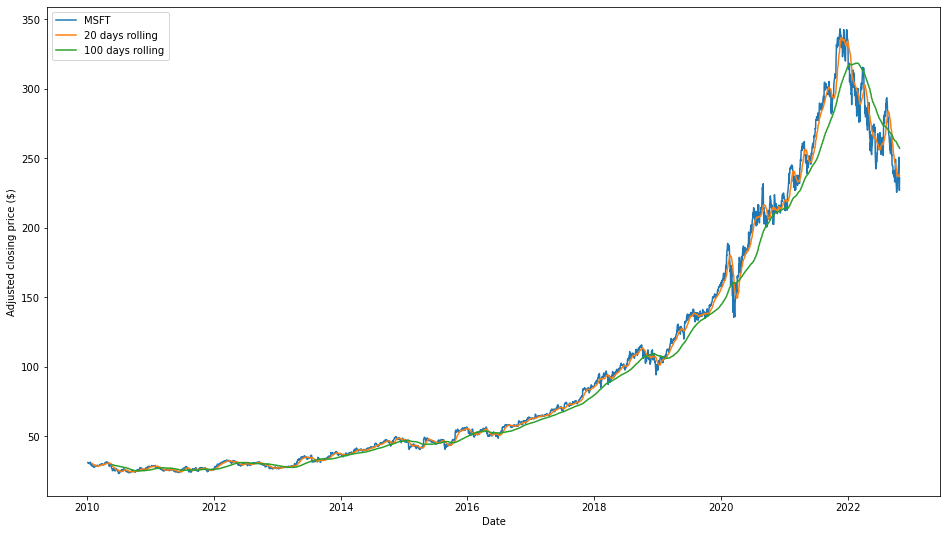

In [78]:
# Get the MSFT timeseries. This now returns a Pandas Series object indexed by date.
msft = close.loc[:, 'MSFT']

# Calculate the 20 and 100 days moving averages of the closing prices
short_rolling_msft = msft.rolling(window=20).mean()
long_rolling_msft = msft.rolling(window=100).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(msft.index, msft, label='MSFT')
ax.plot(short_rolling_msft.index, short_rolling_msft, label='20 days rolling')
ax.plot(long_rolling_msft.index, long_rolling_msft, label='100 days rolling')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()
